# Detección de anomalías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option("display.max_columns",None) 
pd.set_option("display.max_rows",None) 

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('talk')

Un valor atípico es una observación diferente a las otras observaciones. Es raro, distinto o no encaja de alguna manera. También se le llama anomalías.
Tipo de outliers:
* Univariate: solo tenemos en cuenta una variable.
* Multivariate: tenemos en cuenta n-variables.


In [2]:
# Detección de outliers univariable

# cargamos el dataset de heart-disease https://archive.ics.uci.edu/ml/datasets/Heart+Disease
df_1 = pd.read_csv("heart.csv")
df_1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
df_1.shape

(1025, 14)

# Isolation forest

[Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on.](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)

Es un algoritmo para detectar valores atípicos. Divide los datos utilizando un conjunto de árboles y proporciona una puntuación de anomalía que indica qué tan aislado está el punto en la estructura encontrada. 

La puntuación de anomalía se utiliza para diferenciar los valores atípicos de las observaciones normales.

Un concepto importante en este método es el número de aislamiento. El número de aislamiento es el número de divisiones necesarias para aislar un punto de datos. 

El funcionamiento general del algoritmo es de la siguiente manera:
1. Dado un dataset se selecciona una muestra aleatoria de los datos y se asigna a un árbol binario.
2. La ramificación del árbol comienza seleccionando una característica aleatoria del dataset de las `N`disponibles. A continuación, las ramas se generan a partir de un valor aleatorio entre el mínimo y máximo de dicha característica.
3. Si el valor de un punto de datos es menor que el umbral seleccionado, va a la rama izquierda o a la derecha. Y así un nodo se divide en ramas izquierda y derecha.
4. Este proceso desde el paso 2 continúa recursivamente hasta que cada punto de datos está completamente aislado o hasta que se alcanza la profundidad máxima (si está definida).
5. Los pasos anteriores se repiten para construir árboles binarios aleatorios. 

Una vez construidos los árboles hay que detectar las anomalías. La idea principal es que se requieren menos divisiones para aislar un valor atípico que para aislar un valor no atípico, es decir, un valor atípico tiene un **número de aislamiento** más bajo en comparación con un punto no atípico. Por lo tanto, **un punto de datos se define como un valor atípico si su número de aislamiento es inferior al umbral**.

En la propuesta original de Lui. et al 2008, definen **anomaly score**, en base a las longitudes de los caminos: los caminos más cortos indican que tenemos anomalías, mientras que los caminos más largos muestran que hay observaciones normales. 

Nota: la implementación de Isolation Forest de scikit-learn introdujo una modificación del anomaly score. Los valores atípicos están indicados por puntuaciones negativos, mientras que la puntución positivo implica que tenemos valores internos. Y además, introduce el concepto 'contamination'.

- If ‘auto’, the threshold is determined as in the original paper.
- If float, the contamination should be in the range (0, 0.5].

Si utilizamos nuestro propio valor de contamination podemos decir que el umbral se define en función del porcentaje estimado de valores atípicos en los datos.

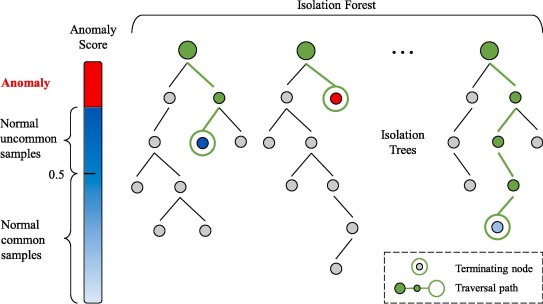

In [4]:
df_1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Documentación de sklearn sobre Isolation Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

Explicación de Isolation Forest en scikit, https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest


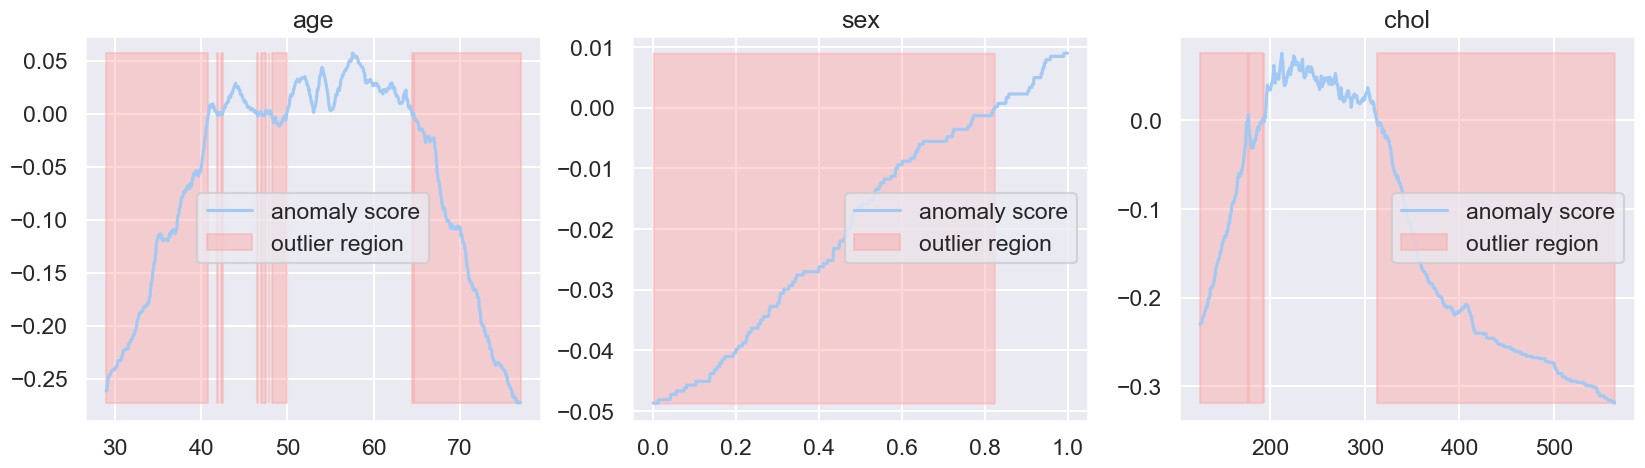

In [5]:
from sklearn.ensemble import IsolationForest
#The required columns
# cols = ['trestbps', 'chol', 'thalach']
cols = ['age','sex','chol']
# cols = ['chol']


#Plotting the sub plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto') #contamination='auto' permite que el algoritmo estime automáticamente la proporción de anomalías en los datos.
    isolation_forest.fit(df_1[column].values.reshape(-1,1)) #.reshape(-1,1) prepara los datos de la columna actual para que sean compatibles con el modelo de Isolation Forest.

    xx = np.linspace(df_1[column].min(), df_1[column].max(), len(df_1)).reshape(-1,1) #crea un conjunto de valores espaciados uniformemente entre el valor mínimo y máximo de la columna actual. Estos valores se utilizarán para generar una curva de puntuación de anomalías.
    anomaly_score = isolation_forest.decision_function(xx) #Se calculan las puntuaciones de anomalía para cada valor en xx utilizando el modelo ajustado. Las puntuaciones de anomalía indican qué tan probable es que un punto de datos sea una anomalía.
    df_1['anomaly'] = outlier = isolation_forest.predict(xx) #Se predicen las etiquetas de anomalía para cada valor en xx.
    
    axs[i].plot(xx, anomaly_score, label='anomaly score') #Se grafica la curva de puntuación de anomalías.
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),  #Se rellena la región de anomalías en el gráfico.
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

In [6]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination='auto')
isolation_forest.fit(df_1)
df_1['anomaly'] = outlier = isolation_forest.predict(df_1)

In [7]:
df_1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,anomaly
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,1
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,-1
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,-1
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,1
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,-1


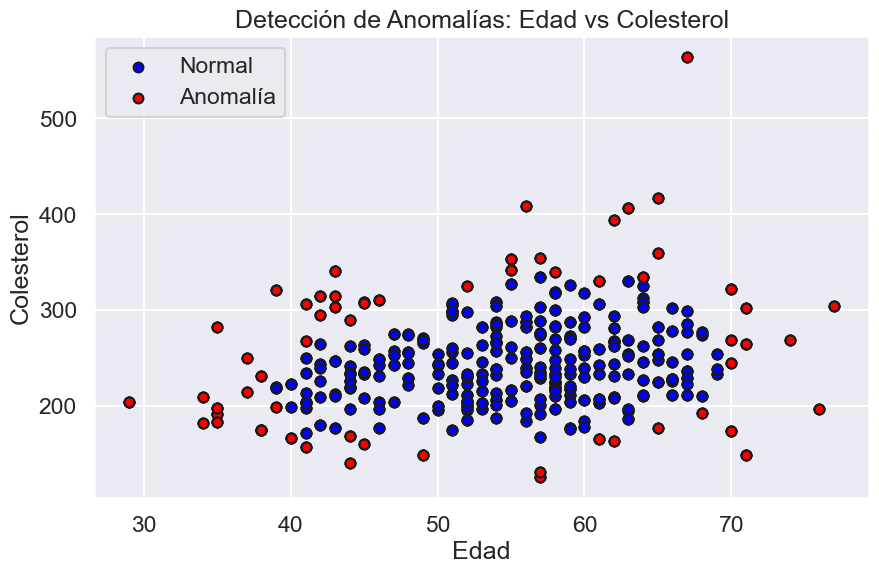

In [8]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Ajustar Isolation Forest solo a las columnas 'age' y 'chol'
isolation_forest = IsolationForest(contamination='auto')
X = df_1[['age', 'chol']]  # Solo seleccionamos las columnas 'age' y 'chol'
isolation_forest.fit(X)

# Obtener las predicciones de anomalías
df_1['anomaly'] = outlier = isolation_forest.predict(X)

# Graficar los resultados
plt.figure(figsize=(10, 6))

# Graficar los puntos normales (anomaly == 1)
plt.scatter(df_1[df_1['anomaly'] == 1]['age'], df_1[df_1['anomaly'] == 1]['chol'], 
            c='blue', label='Normal', edgecolor='k', s=50)

# Graficar los puntos anómalos (anomaly == -1)
plt.scatter(df_1[df_1['anomaly'] == -1]['age'], df_1[df_1['anomaly'] == -1]['chol'], 
            c='red', label='Anomalía', edgecolor='k', s=50)

plt.title('Detección de Anomalías: Edad vs Colesterol')
plt.xlabel('Edad')
plt.ylabel('Colesterol')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Hemos añadido una nueva columna 'anomaly' que nos indica el resultado de IF
# -1 en la columna indica que es anomalía, 1 indica valor normal
df_anomalies = df_1[df_1.anomaly==-1]


In [10]:
# Ver la proporción de anomalías
proporcion_anomalias = len(df_anomalies) / len(df_1)
print(f"Proporción de anomalías: {proporcion_anomalias:.2%}")

Proporción de anomalías: 19.90%


In [11]:
# Contar el número de filas con -1 en la columna 'anomaly'
num_anomalías = (df_1['anomaly'] == -1).sum()
print(f"Número de anomalías detectadas: {num_anomalías}")

Número de anomalías detectadas: 204


Para ampliar conocimientos de Isolation Forest y entender sus limitaciones y una alternativa para solventarlas, recomiendo la lectura del siguiente artículo, S. Hariri, M. C. Kind and R. J. Brunner, "Extended Isolation Forest," in _IEEE Transactions on Knowledge and Data Engineering_, vol. 33, no. 4, pp. 1479-1489, 1 April 2021, doi: 10.1109/TKDE.2019.2947676. https://ieeexplore.ieee.org/abstract/document/8888179

# Multivariate outliers

## Local Outlier Factor Method(LOF)

Breunig, Kriegel, Ng, and Sander (2000) LOF: identifying density-based local outliers. Proc. ACM SIGMOD https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf


LOF utiliza la detección de valores atípicos basada en la densidad para identificar valores atípicos locales, puntos que son valores atípicos con respecto a su vecindario local, en lugar de con respecto a la distribución global de datos. 

Cuanto mayor sea el valor de LOF para una observación, más anómala será la observación.

In [12]:
# En el dataset de enfermedad cardíaca vamos a observar las variables edad y colesterol

clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
#X = df_1[['age','chol', 'sex']].values
X = df_1[['age','chol']].values
y_pred = clf.fit_predict(X)


In [13]:
# Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score
clf.negative_outlier_factor_

array([-1.00338943, -0.95654582, -1.23559606, ..., -1.12571055,
       -0.98983421, -1.0933316 ], shape=(1025,))

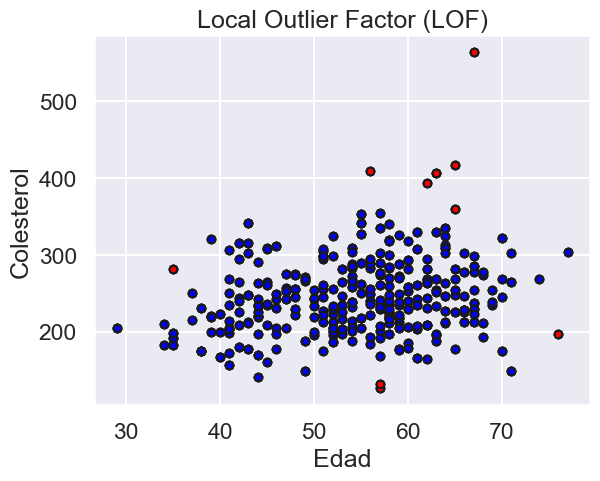

In [14]:
in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")

# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
plt.axis('tight')
plt.xlabel('Edad');
plt.ylabel('Colesterol');

plt.show()

Para ampliar la información sobre LOF se recomienda leer:
- Documentación scikit: [https://scikit-learn.org/stable/modules/outlier_detection.html#id1](Local Outlier Factor)
- Ejemplo en Python: [Outlier detection with Local Outlier Factor (LOF)](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py)




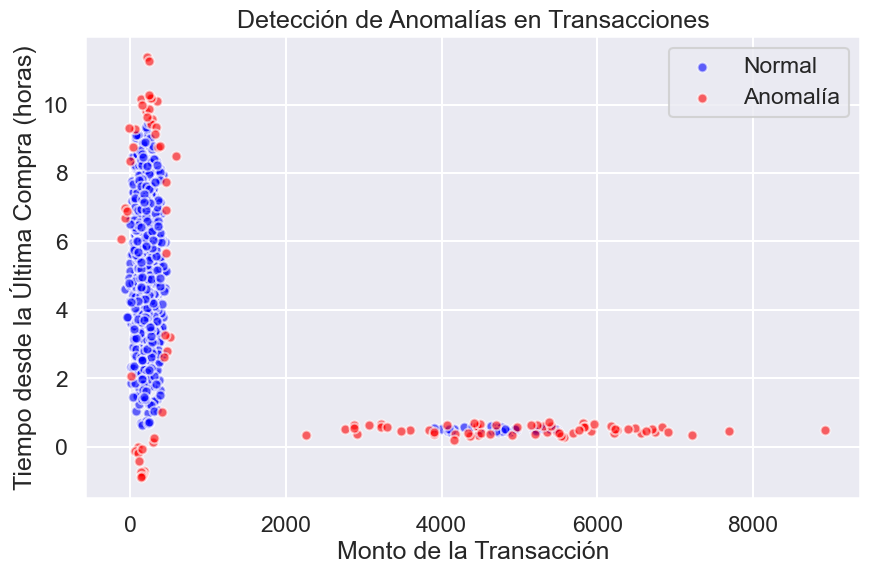

In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Función para generar los datos de fraude
def generate_fraud_data(n_samples=1000):
    np.random.seed(42)
    
    # Generar datos normales (transacciones no fraudulentas)
    normal_amount = np.random.normal(200, 100, size=n_samples)
    normal_time = np.random.normal(5, 2, size=n_samples)
    normal_location = np.random.choice([1, 2], size=n_samples)
    normal_device = np.random.choice([1, 2], size=n_samples)

    # Crear el DataFrame para transacciones normales
    normal_df = pd.DataFrame({
        'amount': normal_amount,
        'time_since_last_purchase': normal_time,
        'location': normal_location,
        'device_used': normal_device,
        'fraud': 1  # 1 = transacción normal
    })

    # Generar transacciones fraudulentas (outliers)
    fraud_amount = np.random.normal(5000, 1000, size=n_samples // 10)  # Transacciones de gran monto
    fraud_time = np.random.normal(0.5, 0.1, size=n_samples // 10)  # Transacciones muy recientes
    fraud_location = np.random.choice([1, 2], size=n_samples // 10)
    fraud_device = np.random.choice([1, 2], size=n_samples // 10)

    # Crear el DataFrame para transacciones fraudulentas
    fraud_df = pd.DataFrame({
        'amount': fraud_amount,
        'time_since_last_purchase': fraud_time,
        'location': fraud_location,
        'device_used': fraud_device,
        'fraud': -1  # -1 = transacción fraudulenta
    })

    # Combinar ambos DataFrames
    df = pd.concat([normal_df, fraud_df], axis=0).reset_index(drop=True)
    return df

# Generar el conjunto de datos
df = generate_fraud_data(n_samples=1000)

# Usar IsolationForest para detectar anomalías
clf = IsolationForest(contamination=0.1)  # 10% de anomalías
X = df[['amount', 'time_since_last_purchase']].values  # Usar 'amount' y 'time_since_last_purchase' para detectar anomalías

# Ajustar el modelo
clf.fit(X)

# Predecir anomalías: 1 = normal, -1 = anómalo
df['predicted_fraud'] = clf.predict(X)

# Separar los puntos normales y anómalos para graficarlos
normal = df[df['predicted_fraud'] == 1]
anomalous = df[df['predicted_fraud'] == -1]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar las transacciones normales
plt.scatter(normal['amount'], normal['time_since_last_purchase'], c='blue', label='Normal', alpha=0.6, edgecolors='w', s=50)

# Graficar las anomalías (fraudulentas)
plt.scatter(anomalous['amount'], anomalous['time_since_last_purchase'], c='red', label='Anomalía', alpha=0.6, edgecolors='w', s=50)

# Añadir etiquetas y título
plt.title('Detección de Anomalías en Transacciones')
plt.xlabel('Monto de la Transacción')
plt.ylabel('Tiempo desde la Última Compra (horas)')
plt.legend(loc='best')

# Mostrar el gráfico
plt.grid(True)
plt.show()


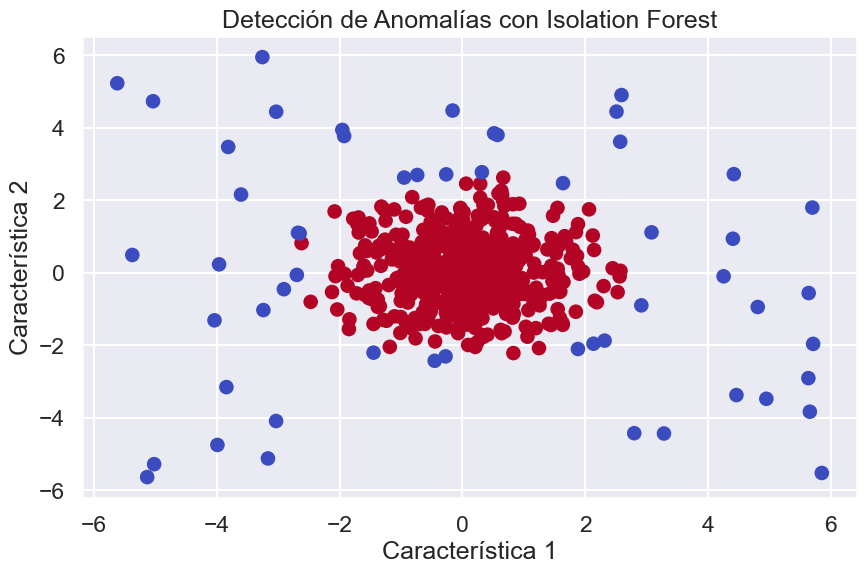

In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Generar datos de muestra (simulación de transacciones)
np.random.seed(42)
n_samples = 500
outliers_fraction = 0.1
features = 2

# Datos normales
X = np.random.randn(n_samples, features)

# Outliers (simulación de transacciones fraudulentas)
outliers = np.random.uniform(low=-6, high=6, size=(int(outliers_fraction * n_samples), features))
X = np.r_[X, outliers]

# Crear el modelo Isolation Forest
clf = IsolationForest(contamination=outliers_fraction, random_state=42)
clf.fit(X)

# Predecir si cada muestra es una anomalía
y_pred = clf.predict(X)

# Visualización
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm')
plt.title("Detección de Anomalías con Isolation Forest")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

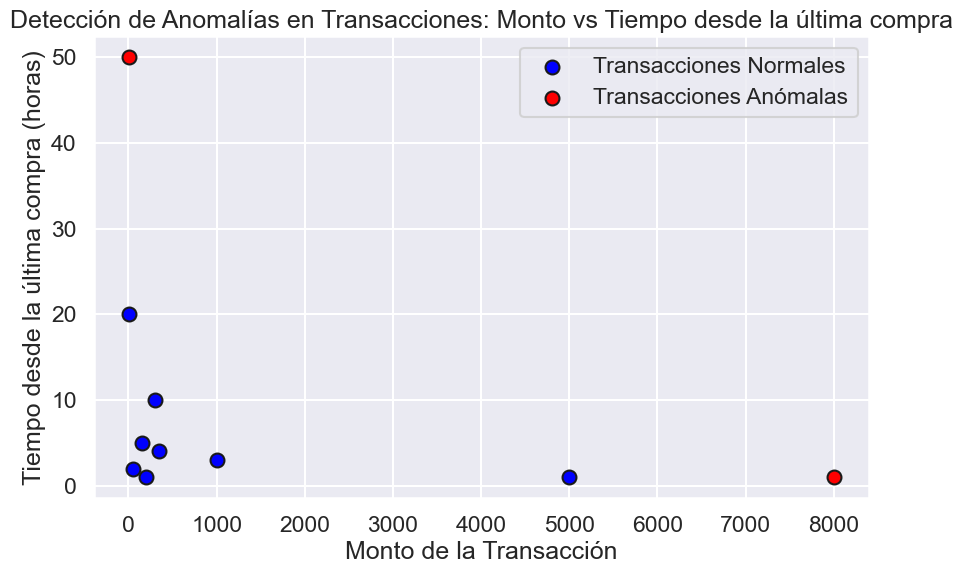

Transacciones Anómalas:
   amount  time_since_last_purchase  location  device_used  anomaly
5      12                        50         2            2       -1
9    8000                         1         2            2       -1


In [17]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulación de un conjunto de datos de transacciones
data = {
    'amount': [50, 150, 200, 5000, 10, 12, 1000, 300, 350, 8000],  # Monto de la transacción
    'time_since_last_purchase': [2, 5, 1, 1, 20, 50, 3, 10, 4, 1],  # Tiempo desde la última compra (en horas)
    'location': [1, 1, 1, 1, 2, 2, 2, 2, 2, 2],  # 1 = país A, 2 = país B
    'device_used': [1, 1, 1, 1, 1, 2, 1, 1, 1, 2]  # 1 = dispositivo habitual, 2 = nuevo dispositivo
}

df = pd.DataFrame(data)

# Definir características de interés para el modelo de anomalías
X = df[['amount', 'time_since_last_purchase', 'location', 'device_used']]

# Ajustar Isolation Forest para detectar anomalías
isolation_forest = IsolationForest(contamination=0.2)  # 20% de los puntos podrían ser anómalos
df['anomaly'] = isolation_forest.fit_predict(X)

# Visualizar las transacciones normales y anómalas
plt.figure(figsize=(10, 6))

# Graficar las transacciones normales
plt.scatter(df[df['anomaly'] == 1]['amount'], df[df['anomaly'] == 1]['time_since_last_purchase'], 
            c='blue', label='Transacciones Normales', edgecolor='k', s=100)

# Graficar las transacciones anómalas
plt.scatter(df[df['anomaly'] == -1]['amount'], df[df['anomaly'] == -1]['time_since_last_purchase'], 
            c='red', label='Transacciones Anómalas', edgecolor='k', s=100)

plt.title('Detección de Anomalías en Transacciones: Monto vs Tiempo desde la última compra')
plt.xlabel('Monto de la Transacción')
plt.ylabel('Tiempo desde la última compra (horas)')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar las transacciones anómalas detectadas
print("Transacciones Anómalas:")
print(df[df['anomaly'] == -1])
